## Quantum Support Vector Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay, roc_curve
import seaborn as sns
from sklearn.manifold import TSNE
from jax_utils import square_kernel_matrix_jax, kernel_matrix_jax, target_alignment_jax

import pennylane.numpy as pnp
import pennylane as qml

import jax
import jax.numpy as jnp
import optax

jax.config.update("jax_enable_x64", True)

seed = 42
np.random.seed(42)

np.random.seed(seed)
pnp.random.seed(seed)

jax.devices()


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

In [3]:
df = pd.read_csv("weather/weather-010824-061024.csv")
df.shape

(1658, 12)

In [4]:
def weather_map(x):
    val = int(x / 100)
    if val == 5:
        return 1
    return 0


df["is_rain"] = df.cod_weather.apply(weather_map)

We only use the highest correlated features to reduce the training overhead of the quantum circuit.

In [5]:
features = [
    "hum",
    "pres",
    "rain_1h",
]
target = "is_rain"

We split the saved train data to train and validation datasets. We also change the labels from 0, 1 to -1, 1 because we will be using Pauli-Z observable in the Quantum Circuit whose eigenvalues are -1, 1.

In [6]:
X = df[features].to_numpy()
y = 2 * df[target].to_numpy() - 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)
X_train.shape, X_test.shape

((1160, 3), (498, 3))

In [7]:
sum(y_train == 1), sum(y_test == 1)

(23, 10)

<Axes: >

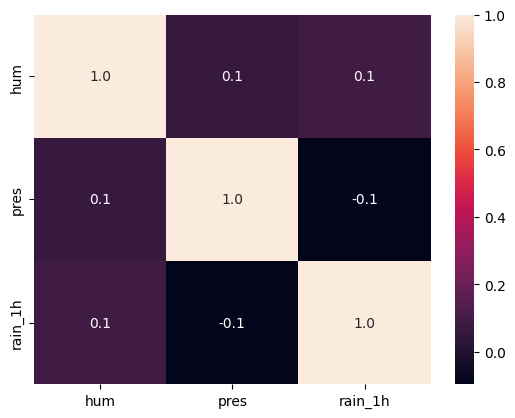

In [8]:
sns.heatmap(df[features].corr('spearman'), annot=True, fmt=".1f")

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mm_scaler = MinMaxScaler((-1, 1))
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

X_train.shape, X_test.shape

((1160, 3), (498, 3))

## Baseline with Data re-uploading

We created a data re-uploading ansatz inspired by the paper [Data re-uploading for a universal quantum classifier](https://quantum-journal.org/papers/q-2020-02-06-226/).  In brief, every feature of the input vector is multiplied with weight and added with a bias i.e. $z_i = w_ix_i + b$. $z_i$ will be passed into the PennyLane's Rot Gate ($R_zR_yR_z$). We use the Rot gate which is $R_zR_yR_z$ repeatedly and for this, the input feature vector has to be a multiple of 3. This block can then be repeated on the single qubit or on more qubits (in this case we can have CZ entanglement).

This will be the $U(x)$ where $x$ is the input feature vector. The actual ansatz will be $U(x)$ $U(x)$† followed by measuring the probs.

We use a single layer of the circuit with 4 qubits.

In [11]:
def feature_map(x, params, n_layers, n_wires):
    """The embedding ansatz"""
    steps = x.shape[0]//3
    qubits = list(range(n_wires))

    # Start with the |+ > state
    for q in qubits:
        qml.Hadamard(wires=q)

    for l in range(n_layers):
        for q in qubits:
            for i in range(steps):

                # Rotation layer
                z = x[3*i:3*i+3]*params[l,q,0,3*i:3*i+3] + params[l,q,1,3*i:3*i+3]
                qml.Rot(z[0], z[1], z[2], wires=q)

        # Entanglement layer
        for i in range(n_wires - 1):
            qml.CZ((i, i + 1))

In [12]:
n_l = 1
n_w = 4
in_shape = 3

params_shape = (n_l, n_w, 2, in_shape)
params = pnp.random.uniform(-np.pi, np.pi, params_shape, requires_grad=True)

dev = qml.device("default.qubit", wires=n_w)

Now, we proceed to define the quantum circuit that implements the kernel. To determine the overlap of the quantum states, we start by applying the embedding of the first data point and then the adjoint of the embedding of the second data point. Finally, we extract the probabilities associated with each basis state for observation.

The kernel function is derived by examining the probability of observing the all-zero state at the end of the kernel circuit.

In [13]:
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    feature_map(x1, params, n_l, n_w)
    qml.adjoint(feature_map)(x2, params, n_l, n_w)
    return qml.probs(wires=range(n_w))

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

In [14]:
print(qml.draw(kernel_circuit)(X_train[0], X_train[1], params))

0: ──H──Rot(0.23,-1.22,-3.62)──╭●────────────────────────────────────╭●─────────────────────
1: ──H──Rot(-0.08,-2.25,2.32)──╰Z─╭●────────╭●───────────────────────╰Z†────────────────────
2: ──H──Rot(-0.94,-1.83,2.15)─────╰Z─╭●─╭●──╰Z†───────────────────────Rot(-1.79,-0.63,2.15)†
3: ──H──Rot(-2.48,-1.74,-1.54)───────╰Z─╰Z†──Rot(-2.31,-0.87,-1.54)†──H†────────────────────

───Rot(0.55,-3.11,-3.62)†──H†─┤ ╭Probs
───Rot(1.05,-3.78,2.32)†───H†─┤ ├Probs
───H†─────────────────────────┤ ├Probs
──────────────────────────────┤ ╰Probs


In [15]:
jit_kernel = jax.jit(kernel)

In [16]:
# Random parameters
init_kernel = lambda x1, x2: jit_kernel(x1, x2, params)
kernel_matrix = lambda X1, X2: kernel_matrix_jax(X1, X2, init_kernel)

In [17]:
model_name = 'qsvc'
base_model = SVC(kernel=kernel_matrix, random_state=seed, probability=True)
base_model.fit(X_train, y_train)

SVC(kernel=<function <lambda> at 0x7a6700fc9090>, probability=True,
    random_state=42)

In [18]:
y_preds = base_model.predict(X_train)
print(sum(y_preds == 1), sum(y_preds == -1))
print(classification_report(y_train, y_preds))

9 1151
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1137
           1       1.00      0.39      0.56        23

    accuracy                           0.99      1160
   macro avg       0.99      0.70      0.78      1160
weighted avg       0.99      0.99      0.99      1160



### QSVC with trainable kernel

We use the [kernel-target alignment](https://link.springer.com/article/10.1007/s10462-012-9369-4) to train the embedding kernel.

In [19]:
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)

for i in range(1000):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X_train))), 4)

    # Define the cost function for optimization
    cost = lambda _params: -target_alignment_jax(
        X_train[subset],
        y_train[subset],
        lambda x1, x2: jit_kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )

    # Optimization step
    grads = jax.grad(cost)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 100 == 0:
        current_alignment = target_alignment_jax(
            X_train,
            y_train,
            lambda x1, x2: jit_kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 100 - Alignment = 0.006
Step 200 - Alignment = 0.006
Step 300 - Alignment = 0.006
Step 400 - Alignment = 0.007
Step 500 - Alignment = 0.007
Step 600 - Alignment = 0.008
Step 700 - Alignment = 0.009
Step 800 - Alignment = 0.009
Step 900 - Alignment = 0.009
Step 1000 - Alignment = 0.009


In [20]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: jit_kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: kernel_matrix_jax(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
qsvc_trained = SVC(probability=True, kernel=trained_kernel_matrix, random_state=seed)

qsvc_trained.fit(X_train, y_train)

SVC(kernel=<function <lambda> at 0x7a66fc900670>, probability=True,
    random_state=42)

In [21]:
y_preds = qsvc_trained.predict(X_train)
print(sum(y_preds == 1), sum(y_preds == -1))
print(classification_report(y_train, y_preds))

14 1146
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      1137
           1       0.86      0.52      0.65        23

    accuracy                           0.99      1160
   macro avg       0.92      0.76      0.82      1160
weighted avg       0.99      0.99      0.99      1160



In [22]:
# We are going to ensure that we have the same splits of the data every time.
kf = StratifiedKFold(n_splits=5, shuffle=False)

score = cross_val_score(qsvc_trained, X_train, y_train, cv=kf, scoring="recall")
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.   0.75 0.4  0.6  0.6 ]
Average Cross Validation Recall score: 0.47000000000000003


In [23]:
y_pred = qsvc_trained.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

baseline_Recall = recall_score(y_test, y_pred)
baseline_Precision = precision_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)
baseline_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[487   1]
 [  4   6]]


In [24]:
ndf = [(baseline_Recall, baseline_Precision, baseline_f1, baseline_accuracy)]

baseline_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
baseline_score.insert(0, f"{model_name} with", "Baseline")
baseline_score

,qsvc with,Recall,Precision,F1 Score,Accuracy
0,Baseline,0.6,0.857143,0.705882,0.98996


## Random oversampling

In [25]:
ro_model = clone(qsvc_trained)
random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), ro_model)

score2 = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.75 1.   1.   0.6  1.  ]
Average Cross Validation Recall score: 0.8699999999999999


In [26]:
X_over, y_over = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
X_over.shape, sum(y_over == 1), sum(y_over == -1)

((2274, 3), 1137, 1137)

In [27]:
ro_params = params.copy()
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(ro_params)

for i in range(1000):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X_over))), 4)

    # Define the cost function for optimization
    cost = lambda _params: -target_alignment_jax(
        X_over[subset],
        y_over[subset],
        lambda x1, x2: jit_kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )

    # Optimization step
    grads = jax.grad(cost)(ro_params)
    updates, opt_state = opt.update(grads, opt_state)
    ro_params = optax.apply_updates(ro_params, updates)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 100 == 0:
        current_alignment = target_alignment_jax(
            X_over,
            y_over,
            lambda x1, x2: jit_kernel(x1, x2, ro_params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 100 - Alignment = 0.166
Step 200 - Alignment = 0.175
Step 300 - Alignment = 0.173
Step 400 - Alignment = 0.174
Step 500 - Alignment = 0.178
Step 600 - Alignment = 0.181
Step 700 - Alignment = 0.180
Step 800 - Alignment = 0.179
Step 900 - Alignment = 0.179
Step 1000 - Alignment = 0.180


In [28]:
# First create a kernel with the trained parameter baked into it.
ro_trained_kernel = lambda x1, x2: jit_kernel(x1, x2, ro_params)

# Second create a kernel matrix function using the trained kernel.
ro_trained_kernel_matrix = lambda X1, X2: kernel_matrix_jax(X1, X2, ro_trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
ro_qsvc_trained = SVC(probability=True, kernel=ro_trained_kernel_matrix, random_state=seed)

ro_qsvc_trained.fit(X_over, y_over)

SVC(kernel=<function <lambda> at 0x7a66cb63b0a0>, probability=True,
    random_state=42)

In [29]:
y_pred = ro_qsvc_trained.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

over_Recall = recall_score(y_test, y_pred)
over_Precision = precision_score(y_test, y_pred)
over_f1 = f1_score(y_test, y_pred)
over_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[479   9]
 [  2   8]]


In [30]:
ndf = [(over_Recall, over_Precision, over_f1, over_accuracy)]

over_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_score.insert(0, f'{model_name} with', 'Random Oversampling')
over_score

,qsvc with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.8,0.470588,0.592593,0.977912


## Smote Tomek

In [31]:
smote_tomek_model = clone(qsvc_trained)
SMOTETomek_pipeline = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy="majority")),
    smote_tomek_model,
)
score = cross_val_score(SMOTETomek_pipeline, X_train, y_train, cv=kf, scoring="recall")
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.75 1.   1.   0.6  0.8 ]
Average Cross Validation Recall score: 0.8300000000000001


In [32]:
X_smote, y_smote = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority")).fit_resample(X_train, y_train)
X_smote.shape, sum(y_smote == 1), sum(y_smote == -1)

((2274, 3), 1137, 1137)

In [33]:
smote_params = params.copy()
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(smote_params)

for i in range(1000):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X_smote))), 4)

    # Define the cost function for optimization
    cost = lambda _params: -target_alignment_jax(
        X_smote[subset],
        y_smote[subset],
        lambda x1, x2: jit_kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )

    # Optimization step
    grads = jax.grad(cost)(smote_params)
    updates, opt_state = opt.update(grads, opt_state)
    smote_params = optax.apply_updates(smote_params, updates)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 100 == 0:
        current_alignment = target_alignment_jax(
            X_smote,
            y_smote,
            lambda x1, x2: jit_kernel(x1, x2, smote_params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 100 - Alignment = 0.176
Step 200 - Alignment = 0.172
Step 300 - Alignment = 0.175
Step 400 - Alignment = 0.179
Step 500 - Alignment = 0.177
Step 600 - Alignment = 0.180
Step 700 - Alignment = 0.178
Step 800 - Alignment = 0.181
Step 900 - Alignment = 0.185
Step 1000 - Alignment = 0.193


In [34]:
# First create a kernel with the trained parameter baked into it.
smote_trained_kernel = lambda x1, x2: jit_kernel(x1, x2, smote_params)

# Second create a kernel matrix function using the trained kernel.
smote_trained_kernel_matrix = lambda X1, X2: kernel_matrix_jax(X1, X2, smote_trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
smote_qsvc_trained = SVC(probability=True, kernel=smote_trained_kernel_matrix, random_state=seed)

smote_qsvc_trained.fit(X_smote, y_smote)

SVC(kernel=<function <lambda> at 0x7a66d4ad8b80>, probability=True,
    random_state=42)

In [35]:
y_pred = smote_qsvc_trained.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

SMOTETomek_Recall = recall_score(y_test, y_pred)
SMOTETomek_Precision = precision_score(y_test, y_pred)
SMOTETomek_f1 = f1_score(y_test, y_pred)
SMOTETomek_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[477  11]
 [  2   8]]


In [36]:
ndf = [
    (
        SMOTETomek_Recall,
        SMOTETomek_Precision,
        SMOTETomek_f1,
        SMOTETomek_accuracy,
    )
]

SMOTETomek_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
SMOTETomek_score.insert(0, f'{model_name} with', "SMOTE + Tomek")
SMOTETomek_score

,qsvc with,Recall,Precision,F1 Score,Accuracy
0,SMOTE + Tomek,0.8,0.421053,0.551724,0.973896


## Class weighted model

In [37]:
qsvc_balanced_trained = SVC(probability=True, kernel=trained_kernel_matrix, class_weight='balanced', random_state=seed)
qsvc_balanced_trained.fit(X_train, y_train)

y_preds = qsvc_balanced_trained.predict(X_train)
print(sum(y_preds == 1), sum(y_preds == -1))
print(classification_report(y_train, y_preds))

27 1133
              precision    recall  f1-score   support

          -1       1.00      0.99      1.00      1137
           1       0.78      0.91      0.84        23

    accuracy                           0.99      1160
   macro avg       0.89      0.95      0.92      1160
weighted avg       0.99      0.99      0.99      1160



In [38]:
score5 = cross_val_score(qsvc_balanced_trained, X_train, y_train, cv=kf, scoring="recall")
print("Cross Validation Recall scores are: {}".format(score5))
print("Average Cross Validation Recall score: {}".format(score5.mean()))

Cross Validation Recall scores are: [0.75 1.   1.   0.6  1.  ]
Average Cross Validation Recall score: 0.8699999999999999


In [39]:
y_pred = qsvc_balanced_trained.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

grid_b_Recall = recall_score(y_test, y_pred)
grid_b_Precision = precision_score(y_test, y_pred)
grid_b_f1 = f1_score(y_test, y_pred)
grid_b_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[484   4]
 [  0  10]]


In [40]:
ndf = [(grid_b_Recall, grid_b_Precision, grid_b_f1, grid_b_accuracy)]

grid_b_score = pd.DataFrame(
    data=ndf, columns=["Recall", "Precision", "F1 Score", "Accuracy"]
)
grid_b_score.insert(0, f'{model_name} with', "Class weights")
grid_b_score

,qsvc with,Recall,Precision,F1 Score,Accuracy
0,Class weights,1.0,0.714286,0.833333,0.991968


In [41]:
predictions = pd.concat(
    [baseline_score, over_score, SMOTETomek_score, grid_b_score], ignore_index=True, sort=False
)
predictions.sort_values(by=["Recall"], ascending=False)

,qsvc with,Recall,Precision,F1 Score,Accuracy
3,Class weights,1.0,0.714286,0.833333,0.991968
1,Random Oversampling,0.8,0.470588,0.592593,0.977912
2,SMOTE + Tomek,0.8,0.421053,0.551724,0.973896
0,Baseline,0.6,0.857143,0.705882,0.989960


In [42]:
predictions.to_csv('results/qsvc.csv')

In [50]:
with open('results/qsvc_balanced_trained_params.npy', 'wb') as f:
    np.save(f, np.array(params))

## Summary

Class weighted model has the best Recall score with slightly less precision compared to baseline model. This configuration offers a strong balance, making it suitable where recall is critical to minimize missed rain events.

## ROC-AUC curve

In [43]:
y_pred = qsvc_balanced_trained.predict(X_test)
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for SVC with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for SVC with Class weights: 0.9959


/home/gopald/Documents/jetix/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


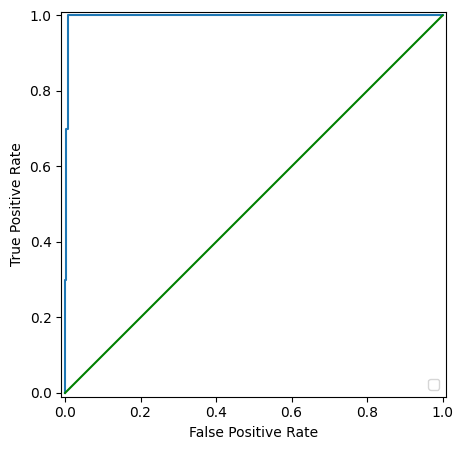

In [44]:
y_proba = qsvc_balanced_trained.predict_proba(X_test)

def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5, 5)
    plt.plot([0, 1], [0, 1], color="g")


plot_auc_roc_curve(y_test, y_proba[:, 1])

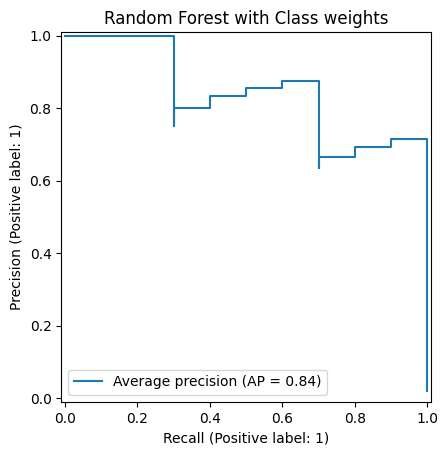

In [45]:
display = PrecisionRecallDisplay.from_estimator(
    qsvc_balanced_trained, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with Class weights")